# Testes de diferentes classificadores - ISCHAEMIA


# OCPC Classifier

In [3]:
import pandas as pd
import numpy as np
import joblib 
import os
import cv2
import time
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from ocpc_py import MultiClassPC
from codecarbon import EmissionsTracker

# Configurações
base_path = "ischaemia/"
image_size = (64, 64)

# Monta dataset
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))

df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Carrega e normaliza imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Validação Cruzada - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    pca = PCA(n_components=50)
    X_tr_pca = pca.fit_transform(X_tr)
    X_val_pca = pca.transform(X_val)

    clf = MultiClassPC()
    clf.fit(X_tr_pca, y_tr)
    y_pred = clf.predict(X_val_pca)
    y_proba = clf.predict_proba(X_val_pca)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Resultados finais do K-Fold
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

# TREINAMENTO FINAL PARA PRODUÇÃO
print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

pca_final = PCA(n_components=50)
X_train_pca = pca_final.fit_transform(X_train)
X_test_pca = pca_final.transform(X_test)

clf_final = MultiClassPC()
clf_final.fit(X_train_pca, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante todo o experimento: {emissions:.6f} kg CO₂eq")

# Avaliação no conjunto de teste
y_pred_test = clf_final.predict(X_test_pca)
y_proba_test = clf_final.predict_proba(X_test_pca)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Medindo tempo de classificação (inference time)
tempos_inferencia = []
for x in X_test_pca:
    inicio = time.time()
    _ = clf_final.predict(x.reshape(1, -1))
    fim = time.time()
    tempos_inferencia.append(fim - inicio)

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.6f} s ± {np.std(tempos_inferencia):.6f} s")

output_dir = "Models/ISCHAEMIA"
os.makedirs(output_dir, exist_ok=True)
pca_path = os.path.join(output_dir, "OCPC_pca_ischaemia.pkl")
clf_path = os.path.join(output_dir, "OCPC_modelo_ischaemia.pkl")
joblib.dump(pca_final, pca_path)
joblib.dump(clf_final, clf_path)


[Validação Cruzada - Treinamento]

[Fold 1]
Acurácia: 0.7038 | Precisão: 0.7279 | Recall: 0.6485 | F1: 0.6859 | AUC: 0.7812

[Fold 2]
Acurácia: 0.6833 | Precisão: 0.7133 | Recall: 0.6450 | F1: 0.6774 | AUC: 0.7624

[Fold 3]
Acurácia: 0.6916 | Precisão: 0.7076 | Recall: 0.6415 | F1: 0.6729 | AUC: 0.7707

[Fold 4]
Acurácia: 0.7074 | Precisão: 0.7281 | Recall: 0.6434 | F1: 0.6831 | AUC: 0.7844

[Fold 5]
Acurácia: 0.7049 | Precisão: 0.7205 | Recall: 0.6713 | F1: 0.6950 | AUC: 0.7796

[Métricas Médias - Cross-Validation]
Acurácia: 0.6982 ± 0.0092
Precisão: 0.7195 ± 0.0081
Recall:   0.6499 ± 0.0109
F1-Score: 0.6829 ± 0.0076
AUC:      0.7757 ± 0.0080

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante todo o experimento: 0.000011 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.7153
Precisão: 0.7244
Recall:   0.6950
F1-Score: 0.7094
AUC:      0.7798
Matriz de Confusão:
[[726 261]
 [301 686]]

[TEMPO DE CLASSIFICAÇÃO]
Tempo médio por imagem: 0.0010

['Models/ISCHAEMIA\\OCPC_modelo_ischaemia.pkl']

# Random Forest

## Random Forest sem PCA

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import time
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
import joblib
from codecarbon import EmissionsTracker 

# Caminho base e configuração
base_path = "ischaemia/"
image_size = (64, 64)

# Montar dataset (imagem, rótulo)
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))
df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Carregar e normalizar imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)

# Separar treino/teste (20% é o holdout final)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# VALIDAÇÃO CRUZADA (K-Fold no treino)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Cross Validation - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_tr, y_tr)

    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Exibir métricas médias
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

clf_final = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
clf_final.fit(X_train, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante o treinamento final: {emissions:.6f} kg CO₂eq")

# Avaliação em teste
y_pred_test = clf_final.predict(X_test)
y_proba_test = clf_final.predict_proba(X_test)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Medindo tempo de classificação (em segundos)
tempos_inferencia = []
for x in X_test:
    inicio = time.time()
    _ = clf_final.predict([x])
    fim = time.time()
    tempos_inferencia.append(fim - inicio)  

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.4f} s ± {np.std(tempos_inferencia):.4f} s")

#Salvando o modelo final
output_dir = "Models/ISCHAEMIA"
os.makedirs(output_dir, exist_ok=True)
clf_path = os.path.join(output_dir, "random_forest_ischaemia.pkl")
joblib.dump(clf_final, clf_path)



[Cross Validation - Treinamento]

[Fold 1]
Acurácia: 0.8684 | Precisão: 0.8607 | Recall: 0.8782 | F1: 0.8693 | AUC: 0.9446

[Fold 2]
Acurácia: 0.8740 | Precisão: 0.8745 | Recall: 0.8821 | F1: 0.8783 | AUC: 0.9444

[Fold 3]
Acurácia: 0.8835 | Precisão: 0.8681 | Recall: 0.9014 | F1: 0.8844 | AUC: 0.9513

[Fold 4]
Acurácia: 0.8765 | Precisão: 0.8535 | Recall: 0.9031 | F1: 0.8776 | AUC: 0.9490

[Fold 5]
Acurácia: 0.8847 | Precisão: 0.8745 | Recall: 0.8989 | F1: 0.8865 | AUC: 0.9566

[Métricas Médias - Cross-Validation]
Acurácia: 0.8774 ± 0.0061
Precisão: 0.8663 ± 0.0082
Recall:   0.8927 ± 0.0105
F1-Score: 0.8792 ± 0.0060
AUC:      0.9492 ± 0.0045

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante o treinamento final: 0.000036 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.8906
Precisão: 0.8806
Recall:   0.9037
F1-Score: 0.8920
AUC:      0.9594
Matriz de Confusão:
[[866 121]
 [ 95 892]]

[TEMPO DE CLASSIFICAÇÃO]
Tempo médio por imagem: 0.0398

['Models/ISCHAEMIA\\random_forest_ischaemia.pkl']

## Random Forest com PCA 

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from codecarbon import EmissionsTracker 
import joblib

# Configurações
base_path = "ischaemia/"
image_size = (64, 64)

# Monta dataset
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))

df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Carrega e normaliza imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Validação Cruzada - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    pca = PCA(n_components=50)
    X_tr_pca = pca.fit_transform(X_tr)
    X_val_pca = pca.transform(X_val)

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_tr_pca, y_tr)
    y_pred = clf.predict(X_val_pca)
    y_proba = clf.predict_proba(X_val_pca)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Resultados finais do K-Fold
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

# TREINAMENTO FINAL PARA PRODUÇÃO
print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

pca_final = PCA(n_components=50)
X_train_pca = pca_final.fit_transform(X_train)
X_test_pca = pca_final.transform(X_test)

clf_final = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
clf_final.fit(X_train_pca, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante o treinamento final: {emissions:.6f} kg CO₂eq")

# Avaliação no conjunto de teste
y_pred_test = clf_final.predict(X_test_pca)
y_proba_test = clf_final.predict_proba(X_test_pca)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Medindo tempo de classificação (em segundos)
tempos_inferencia = []
for x in X_test_pca:
    inicio = time.time()
    _ = clf_final.predict([x])
    fim = time.time()
    tempos_inferencia.append(fim - inicio)  

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.4f} s ± {np.std(tempos_inferencia):.4f} s")

output_dir = "Models/ISCHAEMIA"
os.makedirs(output_dir, exist_ok=True)
pca_path = os.path.join(output_dir, "random_forest_PCA_ischaemia.pkl")
clf_path = os.path.join(output_dir, "random_forest_modelo_PCA_ischaemia.pkl")
joblib.dump(pca_final, pca_path)
joblib.dump(clf_final, clf_path)



[Validação Cruzada - Treinamento]

[Fold 1]
Acurácia: 0.8551 | Precisão: 0.8300 | Recall: 0.8921 | F1: 0.8599 | AUC: 0.9359

[Fold 2]
Acurácia: 0.8651 | Precisão: 0.8474 | Recall: 0.9005 | F1: 0.8731 | AUC: 0.9418

[Fold 3]
Acurácia: 0.8759 | Precisão: 0.8382 | Recall: 0.9283 | F1: 0.8809 | AUC: 0.9491

[Fold 4]
Acurácia: 0.8676 | Precisão: 0.8375 | Recall: 0.9057 | F1: 0.8703 | AUC: 0.9400

[Fold 5]
Acurácia: 0.8607 | Precisão: 0.8363 | Recall: 0.8976 | F1: 0.8659 | AUC: 0.9409

[Métricas Médias - Cross-Validation]
Acurácia: 0.8649 ± 0.0070
Precisão: 0.8379 ± 0.0056
Recall:   0.9048 ± 0.0125
F1-Score: 0.8700 ± 0.0070
AUC:      0.9415 ± 0.0043

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante o treinamento final: 0.000009 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.8723
Precisão: 0.8406
Recall:   0.9189
F1-Score: 0.8780
AUC:      0.9493
Matriz de Confusão:
[[815 172]
 [ 80 907]]

[TEMPO DE CLASSIFICAÇÃO]
Tempo médio por imagem: 0.057

['Models/ISCHAEMIA\\random_forest_modelo_PCA_ischaemia.pkl']

# XGBOOST

## XGBOOST com PCA

In [8]:
import pandas as pd
import numpy as np
import os
import cv2
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from xgboost import XGBClassifier
from codecarbon import EmissionsTracker 

base_path = "ischaemia/"
image_size = (64, 64)

# Monta dataset
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))

df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Carrega e normaliza imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"[AVISO] Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Validação Cruzada - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    pca = PCA(n_components=50)
    X_tr_pca = pca.fit_transform(X_tr)
    X_val_pca = pca.transform(X_val)

    clf = XGBClassifier(
        n_estimators=300, max_depth=8, learning_rate=0.1,
        use_label_encoder=False, eval_metric='logloss',
        scale_pos_weight=1, random_state=42, n_jobs=-1
    )
    clf.fit(X_tr_pca, y_tr)
    y_pred = clf.predict(X_val_pca)
    y_proba = clf.predict_proba(X_val_pca)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Resultados finais do K-Fold
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

# TREINAMENTO FINAL PARA PRODUÇÃO
print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

pca_final = PCA(n_components=50)
X_train_pca = pca_final.fit_transform(X_train)
X_test_pca = pca_final.transform(X_test)

clf_final = XGBClassifier(
        n_estimators=300, max_depth=8, learning_rate=0.1,
        use_label_encoder=False, eval_metric='logloss',
        scale_pos_weight=1, random_state=42, n_jobs=-1
    )
clf_final.fit(X_train_pca, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante o treinamento final: {emissions:.6f} kg CO₂eq")

# Avaliação no conjunto de teste
y_pred_test = clf_final.predict(X_test_pca)
y_proba_test = clf_final.predict_proba(X_test_pca)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Medindo tempo de classificação (em segundos)
tempos_inferencia = []
for x in X_test_pca:
    inicio = time.time()
    _ = clf_final.predict([x])
    fim = time.time()
    tempos_inferencia.append(fim - inicio)  

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.4f} s ± {np.std(tempos_inferencia):.4f} s")

output_dir = "Models/ISCHAEMIA"
os.makedirs(output_dir, exist_ok=True)
pca_path = os.path.join(output_dir, "XGB_PCA_ischaemia.pkl")
clf_path = os.path.join(output_dir, "XGB_modelo_PCA_ischaemia.pkl")
joblib.dump(pca_final, pca_path)
joblib.dump(clf_final, clf_path)



[Validação Cruzada - Treinamento]

[Fold 1]
Acurácia: 0.8804 | Precisão: 0.8786 | Recall: 0.8820 | F1: 0.8803 | AUC: 0.9522

[Fold 2]
Acurácia: 0.8847 | Precisão: 0.8762 | Recall: 0.9042 | F1: 0.8900 | AUC: 0.9568

[Fold 3]
Acurácia: 0.8999 | Precisão: 0.8841 | Recall: 0.9181 | F1: 0.9008 | AUC: 0.9635

[Fold 4]
Acurácia: 0.9056 | Precisão: 0.8892 | Recall: 0.9225 | F1: 0.9055 | AUC: 0.9599

[Fold 5]
Acurácia: 0.8936 | Precisão: 0.8899 | Recall: 0.8989 | F1: 0.8943 | AUC: 0.9604

[Métricas Médias - Cross-Validation]
Acurácia: 0.8929 ± 0.0093
Precisão: 0.8836 ± 0.0055
Recall:   0.9051 ± 0.0145
F1-Score: 0.8942 ± 0.0087
AUC:      0.9585 ± 0.0038

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante o treinamento final: 0.000012 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.9063
Precisão: 0.8871
Recall:   0.9311
F1-Score: 0.9086
AUC:      0.9691
Matriz de Confusão:
[[870 117]
 [ 68 919]]

[TEMPO DE CLASSIFICAÇÃO]
Tempo médio por imagem: 0.000

['Models/ISCHAEMIA\\XGB_modelo_PCA_ischaemia.pkl']

## XGBOOST sem PCA


[Cross Validation - Treinamento]

[Fold 1]
Acurácia: 0.9133 | Precisão: 0.9233 | Recall: 0.9010 | F1: 0.9120 | AUC: 0.9690

[Fold 2]
Acurácia: 0.9069 | Precisão: 0.9133 | Recall: 0.9054 | F1: 0.9093 | AUC: 0.9658

[Fold 3]
Acurácia: 0.9215 | Precisão: 0.9185 | Recall: 0.9232 | F1: 0.9208 | AUC: 0.9750

[Fold 4]
Acurácia: 0.9189 | Precisão: 0.9120 | Recall: 0.9238 | F1: 0.9178 | AUC: 0.9714


[codecarbon WARNING @ 09:24:52] Multiple instances of codecarbon are allowed to run at the same time.



[Fold 5]
Acurácia: 0.9183 | Precisão: 0.9190 | Recall: 0.9178 | F1: 0.9184 | AUC: 0.9746

[Métricas Médias - Cross-Validation]
Acurácia: 0.9158 ± 0.0052
Precisão: 0.9172 ± 0.0041
Recall:   0.9142 ± 0.0093
F1-Score: 0.9157 ± 0.0043
AUC:      0.9712 ± 0.0035

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante o treinamento final: 0.000260 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.9200
Precisão: 0.9191
Recall:   0.9210
F1-Score: 0.9200
AUC:      0.9781
Matriz de Confusão:
[[907  80]
 [ 78 909]]


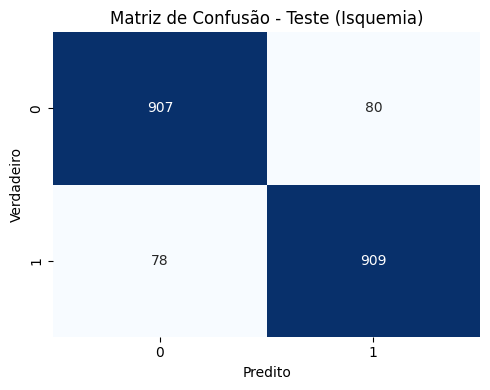


[TEMPO DE CLASSIFICAÇÃO]
Tempo médio por imagem: 0.0008 s ± 0.0008 s


['Models/ISCHAEMIA\\XGB_ischaemia.pkl']

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from xgboost import XGBClassifier
from codecarbon import EmissionsTracker 

# Caminho base e configurações
base_path = "ischaemia/"
image_size = (32, 32)
output_dir = "Models/ISCHAEMIA"
os.makedirs(output_dir, exist_ok=True)

# Montar dataframe com caminhos e rótulos
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        dataset.append((os.path.join(pasta, imagem), label))
df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Função para carregar imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"[AVISO] Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)

# Separar treino/teste (20% é o holdout final)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# VALIDAÇÃO CRUZADA (K-Fold no treino)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Cross Validation - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    clf = XGBClassifier(
        n_estimators=300, max_depth=8, learning_rate=0.1,
        use_label_encoder=False, eval_metric='logloss',
        scale_pos_weight=1, random_state=42, n_jobs=-1
    )
    clf.fit(X_tr, y_tr)

    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Exibir métricas médias
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

clf_final = XGBClassifier(
    n_estimators=300, max_depth=8, learning_rate=0.1,
    use_label_encoder=False, eval_metric='logloss',
    scale_pos_weight=1, random_state=42, n_jobs=-1
)
clf_final.fit(X_train, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante o treinamento final: {emissions:.6f} kg CO₂eq")

# Avaliação em teste
y_pred_test = clf_final.predict(X_test)
y_proba_test = clf_final.predict_proba(X_test)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Gerar e plotar matriz de confusão
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusão - Xgboost (Isquemia)")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix_ischaemia.png"))  # Salva imagem
plt.show()

# Medindo tempo de classificação (em segundos)
import time
tempos_inferencia = []
for x in X_test:
    inicio = time.time()
    _ = clf_final.predict([x])
    fim = time.time()
    tempos_inferencia.append(fim - inicio)  

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.4f} s ± {np.std(tempos_inferencia):.4f} s")

output_dir = "Models/ISCHAEMIA"
os.makedirs(output_dir, exist_ok=True)
clf_path = os.path.join(output_dir, "XGB_ischaemia.pkl")
joblib.dump(clf_final, clf_path)


# MLP

## MLPClassifier com PCA

In [6]:
# ISCHAEMIA COM PCA E MLPClassifier
import pandas as pd
import numpy as np
import os
import cv2
import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.neural_network import MLPClassifier
from codecarbon import EmissionsTracker 

# Configurações
base_path = "ischaemia/"
image_size = (64, 64)

# Monta dataset
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))

df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Carrega e normaliza imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Validação Cruzada - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    pca = PCA(n_components=50)
    X_tr_pca = pca.fit_transform(X_tr)
    X_val_pca = pca.transform(X_val)

    clf = MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )
    clf.fit(X_tr_pca, y_tr)
    y_pred = clf.predict(X_val_pca)
    y_proba = clf.predict_proba(X_val_pca)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Resultados finais do K-Fold
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

# TREINAMENTO FINAL PARA PRODUÇÃO
print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

pca_final = PCA(n_components=50)
X_train_pca = pca_final.fit_transform(X_train)
X_test_pca = pca_final.transform(X_test)

clf_final = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    random_state=42
)
clf_final.fit(X_train_pca, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante o treinamento final: {emissions:.6f} kg CO₂eq")

# Avaliação no conjunto de teste
y_pred_test = clf_final.predict(X_test_pca)
y_proba_test = clf_final.predict_proba(X_test_pca)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Medindo tempo de classificação (em segundos)
tempos_inferencia = []
import time
for x in X_test_pca:
    inicio = time.time()
    _ = clf_final.predict([x])
    fim = time.time()
    tempos_inferencia.append(fim - inicio)  

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.4f} s ± {np.std(tempos_inferencia):.4f} s")

output_dir = "Models/ISCHAEMIA"
os.makedirs(output_dir, exist_ok=True)
pca_path = os.path.join(output_dir, "MLP_PCA_ischaemia.pkl")
clf_path = os.path.join(output_dir, "MLP_modelo_PCA_ischaemia.pkl")
joblib.dump(pca_final, pca_path)
joblib.dump(clf_final, clf_path)




[Validação Cruzada - Treinamento]

[Fold 1]
Acurácia: 0.8589 | Precisão: 0.8518 | Recall: 0.8680 | F1: 0.8598 | AUC: 0.9298

[Fold 2]
Acurácia: 0.8657 | Precisão: 0.8627 | Recall: 0.8796 | F1: 0.8710 | AUC: 0.9401

[Fold 3]
Acurácia: 0.8670 | Precisão: 0.8637 | Recall: 0.8681 | F1: 0.8659 | AUC: 0.9427

[Fold 4]
Acurácia: 0.8651 | Precisão: 0.8484 | Recall: 0.8824 | F1: 0.8651 | AUC: 0.9400

[Fold 5]
Acurácia: 0.8721 | Precisão: 0.8723 | Recall: 0.8723 | F1: 0.8723 | AUC: 0.9377

[Métricas Médias - Cross-Validation]
Acurácia: 0.8658 ± 0.0042
Precisão: 0.8598 ± 0.0086
Recall:   0.8741 ± 0.0059
F1-Score: 0.8668 ± 0.0045
AUC:      0.9381 ± 0.0044

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante o treinamento final: 0.000010 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.8713
Precisão: 0.8887
Recall:   0.8490
F1-Score: 0.8684
AUC:      0.9427
Matriz de Confusão:
[[882 105]
 [149 838]]

[TEMPO DE CLASSIFICAÇÃO]
Tempo médio por imagem: 0.000

['Models/ISCHAEMIA\\MLP_modelo_PCA_ischaemia.pkl']

## MLPClassifier sem PCA

In [7]:
# ISCHAEMIA SEM PCA E COM MLPClassifier
import pandas as pd
import numpy as np
import os
import cv2
import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.neural_network import MLPClassifier
from codecarbon import EmissionsTracker
import time

# Caminho base e configuração
base_path = "ischaemia/"
image_size = (64, 64)

# Montar dataset (imagem, rótulo)
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))
df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Carregar e normalizar imagens
def load_images(df, image_size):
    imagens, labels = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0
            imagens.append(img.flatten())
            labels.append(row["label"])
        else:
            print(f"Imagem não carregada: {row['imagem']}")
    return np.array(imagens), np.array(labels)

X_all, y_all = load_images(df, image_size)

# Separar treino/teste (20% é o holdout final)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# VALIDAÇÃO CRUZADA (K-Fold no treino)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []

print("\n[Cross Validation - Treinamento]")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    clf = MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )
    clf.fit(X_tr, y_tr)

    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)[:, 1]

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred))
    recs.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

    print(f"\n[Fold {fold}]")
    print(f"Acurácia: {accs[-1]:.4f} | Precisão: {precs[-1]:.4f} | Recall: {recs[-1]:.4f} | F1: {f1s[-1]:.4f} | AUC: {aucs[-1]:.4f}")

# Exibir métricas médias
print("\n[Métricas Médias - Cross-Validation]")
print(f"Acurácia: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precisão: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:   {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

print("\n[Treinamento Final e Avaliação em Teste]")
tracker = EmissionsTracker(log_level="ERROR")  # Desabilitar logs detalhados
tracker.start()

clf_final = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    random_state=42
)
clf_final.fit(X_train, y_train)

emissions = tracker.stop()
print(f"\n[Pegada de Carbono]")
print(f"Emissões estimadas durante o treinamento final: {emissions:.6f} kg CO₂eq")

# Avaliação em teste
y_pred_test = clf_final.predict(X_test)
y_proba_test = clf_final.predict_proba(X_test)[:, 1]

print("\n[Desempenho no Conjunto de Teste]")
print(f"Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba_test):.4f}")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

# Medindo tempo de classificação (em segundos)
tempos_inferencia = []
for x in X_test:
    inicio = time.time()
    _ = clf_final.predict([x])
    fim = time.time()
    tempos_inferencia.append(fim - inicio)  

tempos_inferencia = np.array(tempos_inferencia)
print("\n[TEMPO DE CLASSIFICAÇÃO]")
print(f"Tempo médio por imagem: {np.mean(tempos_inferencia):.4f} s ± {np.std(tempos_inferencia):.4f} s")

output_dir = "Models/ISCHAEMIA"
os.makedirs(output_dir, exist_ok=True)
clf_path = os.path.join(output_dir, "MLP_ischaemia.pkl")
joblib.dump(clf_final, clf_path)



[Cross Validation - Treinamento]

[Fold 1]
Acurácia: 0.8108 | Precisão: 0.8291 | Recall: 0.7817 | F1: 0.8047 | AUC: 0.8929

[Fold 2]
Acurácia: 0.8423 | Precisão: 0.8655 | Recall: 0.8219 | F1: 0.8431 | AUC: 0.9212

[Fold 3]
Acurácia: 0.8182 | Precisão: 0.8293 | Recall: 0.7964 | F1: 0.8125 | AUC: 0.9053

[Fold 4]
Acurácia: 0.8296 | Precisão: 0.8389 | Recall: 0.8075 | F1: 0.8229 | AUC: 0.9097

[Fold 5]
Acurácia: 0.8258 | Precisão: 0.8477 | Recall: 0.7952 | F1: 0.8206 | AUC: 0.9084

[Métricas Médias - Cross-Validation]
Acurácia: 0.8254 ± 0.0107
Precisão: 0.8421 ± 0.0136
Recall:   0.8005 ± 0.0134
F1-Score: 0.8208 ± 0.0129
AUC:      0.9075 ± 0.0091

[Treinamento Final e Avaliação em Teste]

[Pegada de Carbono]
Emissões estimadas durante o treinamento final: 0.000088 kg CO₂eq

[Desempenho no Conjunto de Teste]
Acurácia: 0.8029
Precisão: 0.8250
Recall:   0.7690
F1-Score: 0.7960
AUC:      0.8877
Matriz de Confusão:
[[826 161]
 [228 759]]

[TEMPO DE CLASSIFICAÇÃO]
Tempo médio por imagem: 0.0006

['Models/ISCHAEMIA\\MLP_ischaemia.pkl']

# Comparação entre os modelos


[MÉTRICAS FINAIS - MÉDIAS POR MODELO]

Modelo: XGBoost
Acurácia:  0.9078 ± 0.0078
Precisão:  0.8946 ± 0.0106
Recall:    0.9248 ± 0.0057
F1-Score:  0.9094 ± 0.0056
AUC:       0.9690 ± 0.0044

Modelo: SVM
Acurácia:  0.8751 ± 0.0102
Precisão:  0.8702 ± 0.0099
Recall:    0.8820 ± 0.0106
F1-Score:  0.8760 ± 0.0080
AUC:       0.9436 ± 0.0063

Modelo: RandomForest
Acurácia:  0.8776 ± 0.0084
Precisão:  0.8546 ± 0.0128
Recall:    0.9102 ± 0.0077
F1-Score:  0.8814 ± 0.0078
AUC:       0.9506 ± 0.0067

Modelo: MLP
Acurácia:  0.8756 ± 0.0076
Precisão:  0.8805 ± 0.0109
Recall:    0.8690 ± 0.0074
F1-Score:  0.8747 ± 0.0076
AUC:       0.9451 ± 0.0057


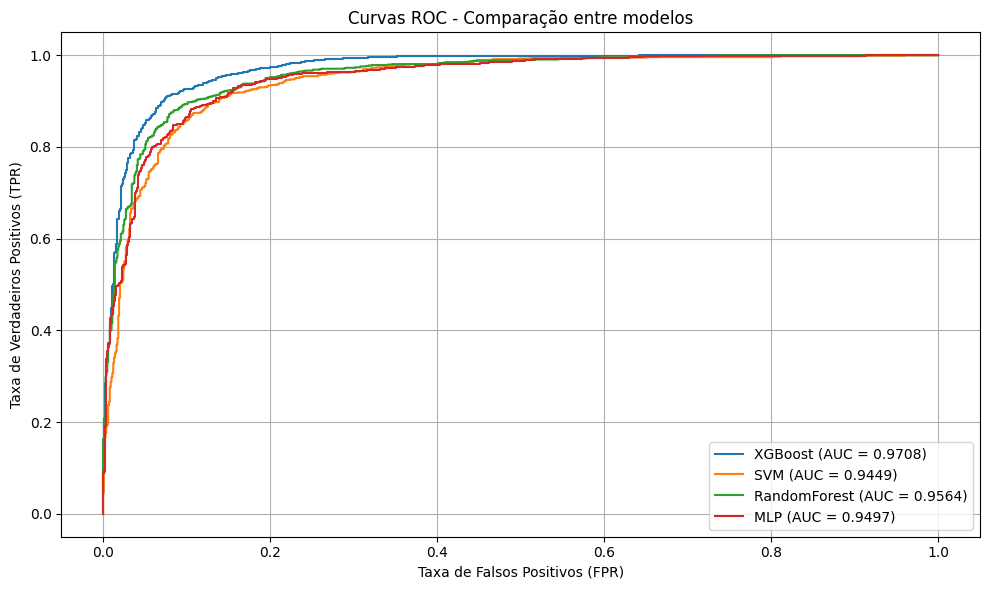

In [4]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Caminho base das imagens e tamanho padronizado
base_path = "ischaemia/"
image_size = (64, 64)

# Montar dataset com caminhos das imagens e rótulos
dataset = []
for classe, label in zip(["Aug-Positive", "Aug-Negative"], [1, 0]):
    pasta = os.path.join(base_path, classe)
    for imagem in os.listdir(pasta):
        caminho_imagem = os.path.join(pasta, imagem)
        dataset.append((caminho_imagem, label))

df = pd.DataFrame(dataset, columns=["imagem", "label"])

# Função para carregar e normalizar imagens
def load_images(df, image_size):
    imagens = []
    labels = []
    for _, row in df.iterrows():
        img = cv2.imread(row["imagem"])
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype("float32") / 255.0  # Normalização para [0, 1]
            img = img.flatten()
            imagens.append(img)
            labels.append(row["label"])
    return np.array(imagens), np.array(labels)

X, y = load_images(df, image_size)

# Inicializar estruturas para salvar métricas por modelo
modelos = {
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=1,
        random_state=42,
        n_jobs=-1
    ),
    "SVM": SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    "MLP": MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    random_state=42
)
}

resultados = {
    nome: {"acc": [], "prec": [], "rec": [], "f1": [], "auc": []}
    for nome in modelos
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    pca = PCA(n_components=50)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    for nome, modelo in modelos.items():
        modelo.fit(X_train_pca, y_train)
        y_pred = modelo.predict(X_test_pca)
        y_proba = modelo.predict_proba(X_test_pca)[:, 1]

        resultados[nome]["acc"].append(accuracy_score(y_test, y_pred))
        resultados[nome]["prec"].append(precision_score(y_test, y_pred))
        resultados[nome]["rec"].append(recall_score(y_test, y_pred))
        resultados[nome]["f1"].append(f1_score(y_test, y_pred))
        resultados[nome]["auc"].append(roc_auc_score(y_test, y_proba))


print("\n[MÉTRICAS FINAIS - MÉDIAS POR MODELO]")
for nome, metricas in resultados.items():
    print(f"\nModelo: {nome}")
    print(f"Acurácia:  {np.mean(metricas['acc']):.4f} ± {np.std(metricas['acc']):.4f}")
    print(f"Precisão:  {np.mean(metricas['prec']):.4f} ± {np.std(metricas['prec']):.4f}")
    print(f"Recall:    {np.mean(metricas['rec']):.4f} ± {np.std(metricas['rec']):.4f}")
    print(f"F1-Score:  {np.mean(metricas['f1']):.4f} ± {np.std(metricas['f1']):.4f}")
    print(f"AUC:       {np.mean(metricas['auc']):.4f} ± {np.std(metricas['auc']):.4f}")


# Redefinir os resultados para salvar as curvas ROC apenas de uma das divisões 
plt.figure(figsize=(10, 6))

for nome, modelo in modelos.items():
    y_proba = modelo.predict_proba(X_test_pca)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{nome} (AUC = {auc:.4f})")


plt.title("Curvas ROC - Comparação entre modelos")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()